# Dealing with dates and years

In [307]:
import pandas as pd
from datetime import datetime
import re

df = pd.read_excel("GSAF5.xls")

## Normalize dates

- `Reported` was removed from the date column
- `Sept` is not an accepted `datetime` so it was replaced with `Sep`
- There was a typo in one record `Nox` instead of `Nov`

In [308]:
def normalize_date(date):
    if isinstance(date, datetime): return date
    date = str(date).strip().lower()
    date = date.replace("reported", "")
    date = date.replace("september", "sep")
    date = date.replace("sept", "sep")
    date = date.replace("nox", "nov")
    return date

## Format dates

### Defining regular expressions

- **Short dates:** 30-Oct-2024 or similar
- **Long dates:** 30-October-2024 or similar
- **Years**: 4 consecutive numbers

### Running regular expressions
- If the date is already a Python `datetime` object, return the date as it is
- First match long dates, short dates then years
- Parse these dates into a Python `datetime` object
- If there are any errors, return the date as it is

In [369]:
short_date_regex = "([0-9]{1,2})[-\\s]+([a-zA-Z]{3,4})[-\\s]+([0-9]{4})"
long_date_regex = "([0-9]{1,2})[-\\s]+([a-zA-Z]{4,10})[-\\s]+([0-9]{4})"
# year_regex = "^[0-9]{4}$"

def match_date(regex, date):
    match = re.search(regex, date)
    if match:
        day = match.group(1).zfill(2)
        month = match.group(2)
        year = match.group(3)
        return datetime.strptime(f"{day}/{month}/{year}", "%d/%B/%Y")
    return None

def format_date(date):
    if isinstance(date, datetime): return date

    try:
        long_date = match_date(long_date_regex, date)
        if long_date: return long_date

        short_date = match_date(short_date_regex, date)
        if short_date: return short_date

        return None
        # year_match = re.search(year_regex, date)
        # if year_match: return None
    except ValueError: return None

## Normalize years

- For years greater than or equal to 1000, return them as they are
- For dates between 100 and 999 (e.g. 950), add `1` to the beginning (e.g. 1950)
- For dates between 25 and 99 (e.g. 93), add `19` to the beginning (e.g. 1993)
- For dates between 10 and 24 (e.g. 24), add `20` to the beginning (e.g. 2024)
- For dates between 0 and 9 (e.g. 4), add `200` to the beginning (e.g. 2004)

In [313]:
def normalize_year(year):
    if year >= 1000: return year
    if year >= 100: return float(f"1{year}")
    if year >= 25: return float(f"19{year}")
    if year >= 10: return float(f"20{year}")
    if year >= 0: return float(f"200{year}")
    return year

## Infer years from dates

If a year is missing and the date record is present, use the year part from the date column

In [315]:
def infer_year(row):
    if pd.isnull(row.Year) and not pd.isnull(row.Date) and isinstance(row.Date, datetime):
        row.Year = row.Date.year
    return row

## Month grouping and time sanitization

In [317]:
def month_grouping(date):
    if not isinstance(date, datetime): return date
    return date.strftime("%B")

def sanitize_time(time):
    long_time_regex = "([0-9]{1,2})[hr\\s\\.]*([0-9]{2})"
    short_time_regex = "([0-9]{1,2})[hr\\s\\.]*"

    if time in ["Not advised", "Not stated", "?"]: return None
    if not isinstance(time, str): time = str(time)
    
    try:
        long_time = re.search(long_time_regex, time)
        if long_time:
            hours = long_time.group(1).zfill(2)
            minutes = long_time.group(2)
            return f"{hours}:{minutes}"

        short_time = re.search(short_time_regex, time)
        if short_time:
            hours = short_time.group(1).zfill(2)
            return f"{hours}:00"

        return None
    except ValueError: return time

## Apply functions to DataFrame

1. Normalize date
2. Format date
3. Drop empty dates otherwise
4. Normalize year
5. Infer year
6. Month grouping
7. Sanitize time

In [371]:
df_copy = df.copy()

df_copy.Date = df_copy.Date.apply(normalize_date)
df_copy.Date = df_copy.Date.apply(format_date)

df_copy.Year = df_copy.Year.apply(normalize_year)
df_copy[["Date", "Year"]] = df_copy[["Date", "Year"]].apply(infer_year, axis=1)

df_copy = df_copy.dropna(subset="Date")

df_copy["Month"] = df_copy["Date"].apply(month_grouping)
df_copy["Time"] = df_copy["Time"].apply(sanitize_time)

df_copy.nunique()

Date              399
Year              124
Type                7
Country            74
State             121
Location          378
Activity          145
Name              393
Sex                 3
Age               110
Injury            360
Unnamed: 11         3
Time               73
Species           190
Source            391
pdf               406
href formula      406
href              406
Case Number       405
Case Number.1     405
original order    407
Unnamed: 21         0
Unnamed: 22         0
Month               8
dtype: int64

In [321]:
sharks_df = df_copy.copy()

sharks_df['Country'] = sharks_df['Country'].str.split(' / ')

#Explode the Country lists into separate rows
sharks_df = sharks_df.explode('Country')
sharks_df["Country"].unique()
#sharks_df["Country"].nunique()

#replace bad entries with a single country but too repetitive doesn't show true data cleaning
sharks_df['Country'] = sharks_df['Country'].replace({'CEYLON (SRI LANKA)': 'Sri Lanka'})
sharks_df['Country'] = sharks_df['Country'].replace({'ST HELENA, British overseas territory': 'Saint Helena'})



sharks_df["Country"] = sharks_df["Country"].str.lower()
sharks_df = sharks_df.dropna(subset=['Country'])

#sharks_df["Country"] = sharks_df["Country"].replace({"?": ""})
#Call method strip to strip off question marks at the end
sharks_df['Country'] = sharks_df['Country'].str.strip('?')

#call is in method to remove oceans+seas+continents

# Wordslist to remove
words_to_remove = ['Asia', 'Africa' , 'ocean' , 'sea']
mask = ~sharks_df['Country'].isin(words_to_remove)
# df_cleaned = df[mask]

In [323]:
df_copy.shape

(6061, 24)

In [325]:
df_copy.head(10)

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22,Month
0,2024-10-14 00:00:00,2024.0,Unprovoked,Honduras,Tela,Atlantida,Swimming,Roberto Carlose Bu Mejia,M,38,...,Georgienne Bradley: Daily Mail UK: FTN News.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,October
1,2024-10-11 00:00:00,2024.0,Unprovoked,USA,Florida,Brevard County Orlando,Surfing,Teddy Witteman,M,16,...,Todd SmithFlorida today: News 4:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,October
2,2024-09-17 00:00:00,2024.0,Unprovoked,Honduras,Trujillo Colon,Puerto Castillo,Diving for shellfish,Fernando Mendoza Ocampo,M,33,...,Daily Mail UK: The Sun UK: The World Watch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,September
3,2024-09-16 00:00:00,2024.0,Unprovoked,Morocco,Southern Morocco,West of Dakhla,Swimming - jumped off yacht,German Tourist,F,30,...,Andy Currie: Moroccan World News: Sky News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,September
4,2024-08-26 00:00:00,2024.0,Unprovoked,Jamaica,Montego Bay,Falmouth,Spearfishing,Jahmari Reid,M,16,...,Todd Smith: Daily Mail UK: Sky News: People .com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,August
5,2024-08-06 00:00:00,2024.0,Unprovoked,Belize,Gulf of Honduras,Central America,Swimming - Diving,Annabelle Carlson,F,15,...,Kevin McMurray Tracking Sharks.com New York Po...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,August
6,2024-07-23 00:00:00,2024.0,Unprovoked,Australia,NSW,"North Shore Beach, Port Macquarie",Surfing,Kai McKenzie,M,23,...,Nine.com.au: ABC.Net.Au Johannes Marchand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,July
7,2024-07-18 00:00:00,2024.0,Unprovoked,Australia,Western Australia,Trigg beach Sterling,Surfing,Ryan Lowther,M,41,...,Daily Mail: Sky News: The West Australian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,July
8,2024-07-08 00:00:00,2024.0,Unprovoked,USA,Florida,Ponce de Leon Inlet Volusia County,Diving into Water,Dempsey Manhart,M,14,...,Miami Herald,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,July
9,2024-07-05 00:00:00,2024.0,Unprovoked,USA,Florida,New Smyrna Beach,Wading,Not stated,M,26,...,Sacbee Fox 35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,July


In [327]:
df_copy["Date"]

0                                     2024-10-14 00:00:00
1                                     2024-10-11 00:00:00
2                                     2024-09-17 00:00:00
3                                     2024-09-16 00:00:00
4                                     2024-08-26 00:00:00
                              ...                        
6916                                  before  19-jun-1959
6917                                  before  24 apr-1959
6959                                   before 17-jul-1916
6960    no date (3 days after preceding incident) & pr...
6961                                   before 19-jul-1913
Name: Date, Length: 6061, dtype: object

In [329]:
print(df_copy.nunique())

Date              5332
Year               223
Type                12
Country            199
State              767
Location          4047
Activity          1336
Name              5111
Sex                  8
Age                233
Injury            3657
Unnamed: 11         10
Time               279
Species           1565
Source            4694
pdf               5882
href formula      5878
href              5869
Case Number       5871
Case Number.1     5869
original order    5888
Unnamed: 21          1
Unnamed: 22          2
Month             4941
dtype: int64


In [331]:
columns_few_unique_values= ["Year", "Type", "Sex"]

In [222]:
for column in columns_few_unique_values: 
    unique_values= df_copy[column].unique()
    print(f"unique values for {column}:")
    print(unique_values)
    print()

unique values for Year:
[2024. 2026. 2025. 2023. 2022. 2021. 2020. 2019. 2018. 2017.   nan 2016.
 2015. 2014. 2013. 2012. 2011. 2010. 2009. 2008. 2007. 2006. 2005. 2004.
 2003. 2002. 2001. 2000. 1999. 1998. 1997. 1996. 1995. 1984. 1994. 1993.
 1992. 1991. 1990. 1989. 1969. 1988. 1987. 1986. 1985. 1983. 1982. 1981.
 1980. 1979. 1978. 1977. 1976. 1975. 1974. 1973. 1972. 1971. 1970. 1968.
 1967. 1966. 1965. 1964. 1963. 1962. 1961. 1960. 1959. 1958. 1957. 1956.
 1955. 1954. 1953. 1952. 1951. 1950. 1949. 1948. 1848. 1947. 1946. 1945.
 1944. 1943. 1942. 1941. 1940. 1939. 1938. 1937. 1936. 1935. 1934. 1933.
 1932. 1931. 1930. 1929. 1928. 1927. 1926. 1925. 1924. 1923. 1922. 1921.
 1920. 1919. 1918. 1917. 1916. 1915. 1914. 1913. 1912. 1911. 1910. 1909.
 1908. 1907. 1906. 1905. 1904. 1903. 1902. 1901. 1900. 1899. 1898. 1897.
 1896. 1895. 1894. 1893. 1892. 1891. 1890. 1889. 1888. 1887. 1886. 1885.
 1884. 1883. 1882. 1881. 1880. 1879. 1878. 1877. 1876. 1875. 1874. 1873.
 1872. 1871. 1870. 1869. 18

In [333]:
categorical_variables = ["Activity"]

In [335]:
for column in categorical_variables:
    print(df_copy[column].value_counts())

Activity
Surfing                                                                                    1090
Swimming                                                                                    900
Fishing                                                                                     431
Spearfishing                                                                                317
Wading                                                                                      163
                                                                                           ... 
Water-skiing                                                                                  1
Surfing & dangling foot in water amid baitfish                                                1
Floating on air mattress                                                                      1
14 m prawn trawler New Venture capsized  & sank in heavy seas Three people in the water       1
Crossing river on a raft       

In [337]:
print(df_copy["State"].value_counts())

State
Florida                        1113
New South Wales                 490
Queensland                      330
California                      313
Hawaii                          312
                               ... 
New Mexico                        1
Bay Islands                       1
South Ch'ungch'ong Province       1
Shanghai                          1
Island of Volos                   1
Name: count, Length: 767, dtype: int64


In [339]:
!pip install seaborn

In [340]:
import seaborn as sns

<Axes: xlabel='Sex', ylabel='count'>

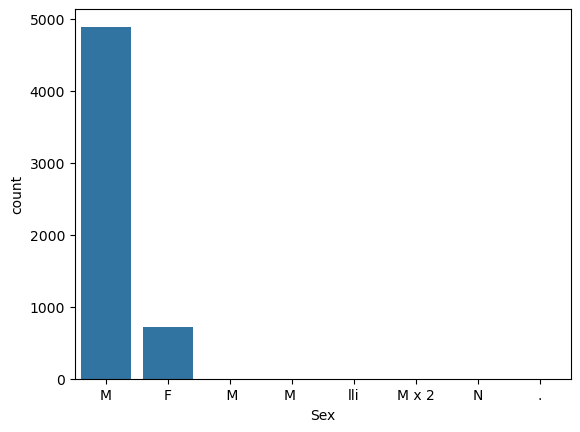

In [341]:
sns.countplot(x='Sex', data=df_copy)

<Axes: xlabel='Year', ylabel='count'>

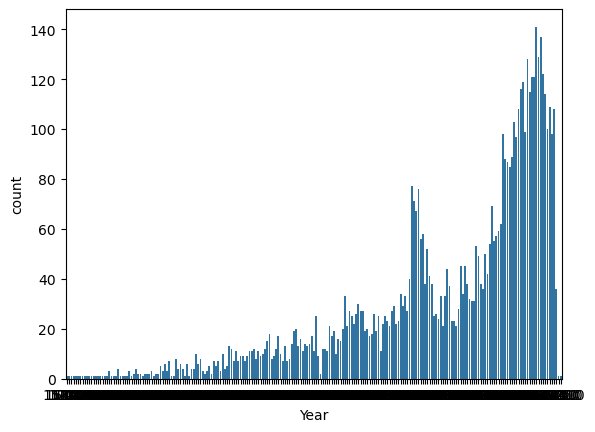

In [344]:
sns.countplot(x='Year', data=df_copy)

<Axes: xlabel='Type', ylabel='count'>

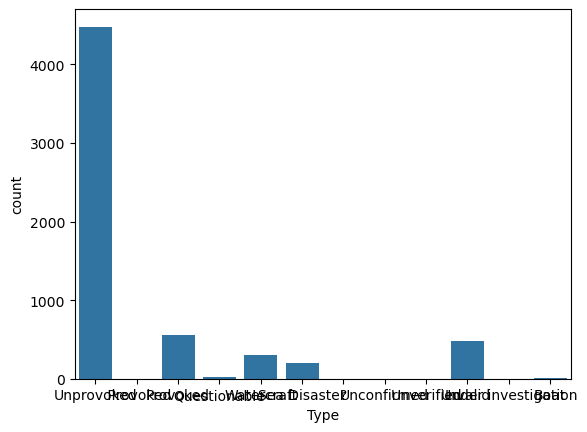

In [346]:
sns.countplot(x='Type', data=df_copy)

<Axes: xlabel='Country', ylabel='count'>

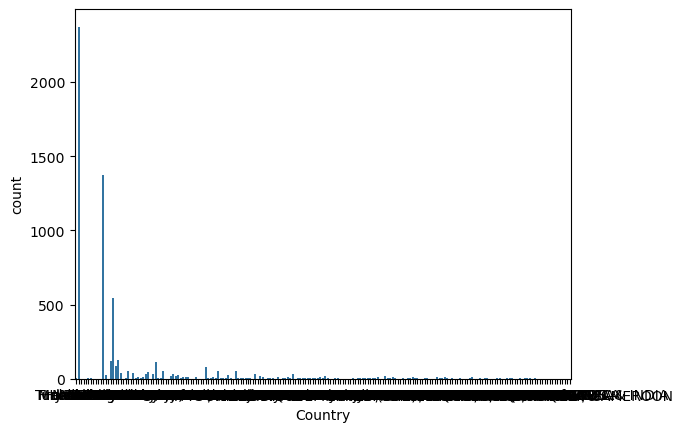

In [347]:
sns.countplot(x='Country', data=df_copy)

<Axes: xlabel='State', ylabel='count'>

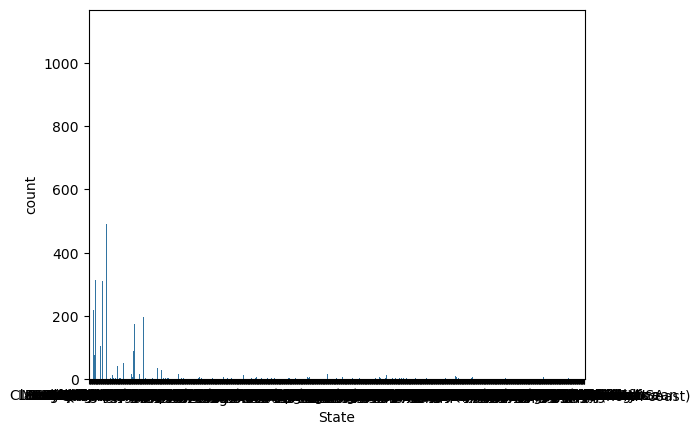

In [349]:
sns.countplot(x='State', data=df_copy)

<Axes: xlabel='Activity', ylabel='count'>

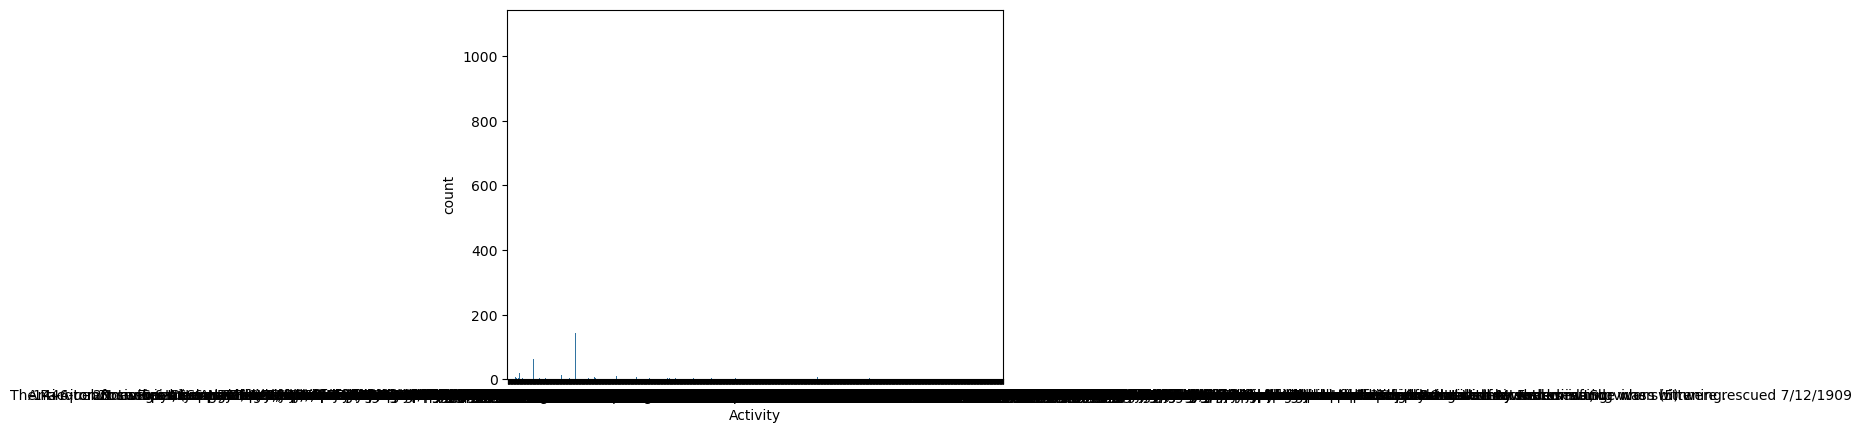

In [351]:
sns.countplot(x='Activity', data=df_copy)

<Axes: xlabel='Age', ylabel='count'>

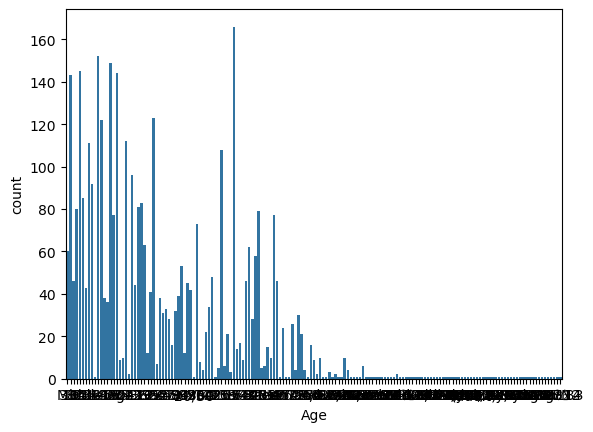

In [353]:
sns.countplot(x='Age', data=df_copy)

In [354]:
print(df_copy["Age"].value_counts())

Age
19             89
16             88
17             85
18             81
17             81
               ..
77              1
Teens           1
28, 23 & 30     1
46 & 34         1
1               1
Name: count, Length: 233, dtype: int64


In [355]:
print(df_copy["Injury"].value_counts())

Injury
FATAL                                                                      693
Foot bitten                                                                 90
Survived                                                                    71
Leg bitten                                                                  70
No injury                                                                   64
                                                                          ... 
No injury to occupants; shark nudged the 5.3 m boat                          1
2 bite marks on right calf                                                   1
Severe bite to right leg FATAL                                               1
No injury to occupant; shark bumped the kayak repeatedly for 15 minutes      1
FATAL, leg stripped of flesh                                                 1
Name: count, Length: 3657, dtype: int64


In [357]:
print(df_copy["Time"].value_counts())

Time
11:00    137
15:00    129
16:00    123
12:00    119
14:00    119
        ... 
15:25      1
19:05      1
10:43      1
17:34      1
01:50      1
Name: count, Length: 279, dtype: int64


In [358]:
df_copy.groupby("Month").size()

Month
      03-mar-2000                                                   1
      05-jan-1988                                                   1
      10-dec-1994                                                   1
      10-nov-1983                                                   1
      13-apr-2007                                                   1
                                                                   ..
no date (3 days after preceding incident) & prior to 19-jul-1913    1
no date, before 3-jan-1967                                          1
reportd 15-jul-1894                                                 1
reprted 05-jan-1882                                                 1
some time between 08-jan-1928 & 21-jan-1928                         1
Length: 4941, dtype: int64

In [365]:
# Function to convert month input to a number
def get_month_number(month_input):
    try:
        # Try to convert directly if input is numeric
        return int(month_input)
    except ValueError:
        # Convert string month names (e.g., "aug" or "August") to month number
        month_input = month_input.strip().lower()
        months = {name.lower(): num for num, name in enumerate(calendar.month_name) if name}
        months.update({name.lower(): num for num, name in enumerate(calendar.month_abbr) if name})
        return months.get(month_input)

In [439]:
# Get user input for location and month
location = "Florida" # input("Enter the location you'd like to search for: ").strip().title()
month_input = "05" # input("Enter the month (e.g., 'Aug', 'August', or '08'): ").strip()

# Convert month input to a number
month = get_month_number(month_input)

# Check if the month is valid
if month is None:
    print(f"Invalid month input: '{month_input}'")
else:
    # Filter data by location and specified month (ignoring the year)
    filtered_data = df_copy[
        (df_copy['State'].str.contains(location, case=False, na=False)) &
        (df_copy['Date'].dt.month == month)
    ]

    # Check if any records were found
    if filtered_data.empty:
        print(f"No shark attack records found for location '{location}' in month '{month_input}'.")
    else:
        print(f"Shark attack records found for location '{location}' in month '{month_input}':")
        display(filtered_data)
        print("Percentage %.2f " % (100 * len(filtered_data) / len(df_copy)))


Shark attack records found for location 'Florida' in month '05':


,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22,Month
109,2023-05-19,2023.0,Provoked,USA,Florida,"Flagship Drive, Summerland Key, Monroe County",Fishing,male,M,35,...,"AP, 5/19/2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May
110,2023-05-18,2023.0,Unprovoked,USA,Florida,"Marathon, Monroe County",Spearfishing,Kevin Blanco,M,20,...,"J. Marchand, GSAF",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May
113,2023-05-11,2023.0,Unprovoked,USA,Florida,"Fort Pierce, St. Lucie County",Sitting,Ella Reed,F,13,...,".A. Curriie, GSAF",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May
116,2023-05-05,2023.0,Unprovoked,USA,Florida,"Davis Reef, Islamorada, Monroe County",Spearfishing,Ethan Wilder,M,22,...,"News19, 5/5/2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May
313,2021-05-06,2021.0,Unprovoked,USA,Florida,"Daytona Beach Shores, Volusia County",Wading,female,F,21,...,"Daytona Beach News-Journal, 5/6/2021",2021.05.05-Daytona.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2021.05.06,2021.05.06,6657.0,NaN,NaN,May
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,1914-05-14,1914.0,Provoked,USA,Florida,"Boca Ciega Bay, Pinellas County",Fishing,Mrs. A.L. Cummings,F,NaN,...,"Evening Independent, 5/14/1914, p.1",1914.05.14-Cummings.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1914.05.14,1914.05.14,971.0,NaN,NaN,May
6020,1913-05-21,1913.0,Provoked,USA,Florida,"John's Pass, Pinellas County",Fishing,George Roberts,M,NaN,...,"Evening Independent, 5/22/1913",1913.05.21-Roberts.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1913.05.21,1913.05.21,952.0,NaN,NaN,May
6100,1908-05-10,1908.0,Invalid,USA,Florida,"Marathon, Monroe County",NaN,John C. Williams,M,NaN,...,"Weekly Miami Metropolis, 5/11/1908",1908.05.10-Williams.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1908.05.10,1908.05.10,872.0,NaN,NaN,May
6157,1905-05-22,1905.0,Unprovoked,USA,Florida,"Pablo Beach, Jacksonville, Duval County",Swimming,Dunham Coxetter,M,NaN,...,"Atlanta Constitution, 5/23/1905",1905.05.22.R-Coxetter.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1905.05.22,1905.05.22,815.0,NaN,NaN,May


Percentage 20.80 
